# Отчет


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import json
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import pickle

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [2]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData_tabular/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_data = pd.concat(df_list)

del df_list

In [34]:
df_data.shape

(2000000, 45)

In [3]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [5]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [7]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50479949999999996

In [8]:
df_data.opponent_hero_card_id.nunique()

9

In [9]:
df_data.player_hero_card_id.nunique()

9

## Преобразуем категориальные признаки

In [4]:
from sklearn.preprocessing import OneHotEncoder

In [5]:
ohe = OneHotEncoder(sparse=False)

In [6]:
new_feat = ohe.fit_transform(df_data.opponent_hero_card_id.values.reshape(-1,1))

In [7]:
df1 = pd.DataFrame(new_feat, columns=["opponent_hero_id_"+str(i+1) for i in xrange(new_feat.shape[1])], index=df_data.index)
df_data = pd.concat([df_data, df1], axis=1)

In [8]:
new_feat = ohe.fit_transform(df_data.player_hero_card_id.values.reshape(-1,1))
df1 = pd.DataFrame(new_feat, columns=["player_hero_id_"+str(i+1) for i in xrange(new_feat.shape[1])], index=df_data.index)
df_data = pd.concat([df_data, df1], axis=1)

In [9]:
del_cols = ["opponent_hero_card_id", "player_hero_card_id"]
cols = [x for x in df_data.columns if x not in del_cols]
df_data = df_data[cols]

In [42]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1.0,1.0,1.0,1.0,0.0
turn,14.0,7.0,5.0,8.0,13.0
opponent_armor,0.0,0.0,3.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hp,5.0,22.0,29.0,26.0,30.0
opponent_special_skill_used,0.0,0.0,0.0,0.0,0.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,6.0,4.0,7.0,10.0
opponent_crystals_current,10.0,6.0,1.0,7.0,1.0
opponent_deck_count,11.0,19.0,22.0,17.0,12.0


## Нормализация данных

In [10]:
X_train = df_data.drop('decision', axis=1)
y_train = df_data.decision.values

In [11]:
dataScaler = StandardScaler().fit(X_train)

In [12]:
X_train = dataScaler.transform(X_train)

In [13]:
X_train.shape

(2000000, 59)

# Выбор модели и подбор параметров

## Логистическая регрессия

In [14]:
lr = LogisticRegression(solver='sag', verbose=2, n_jobs=4)

In [32]:
gs = GridSearchCV(lr, {'C':np.linspace(0.0001, 0.3, 10)}, scoring='roc_auc', verbose=2)

In [33]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.0001 ........................................................
convergence after 12 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.2s finished


[CV] ......................................... C=0.0001, total=  36.4s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.7s remaining:    0.0s


convergence after 15 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.6s finished


[CV] ......................................... C=0.0001, total=  34.6s
[CV] C=0.0001 ........................................................
convergence after 13 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.3s finished


[CV] ......................................... C=0.0001, total=  25.0s
[CV] C=0.0334222222222 ...............................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.9s finished


[CV] ................................ C=0.0334222222222, total=  31.4s
[CV] C=0.0334222222222 ...............................................
convergence after 17 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.4s finished


[CV] ................................ C=0.0334222222222, total=  31.2s
[CV] C=0.0334222222222 ...............................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.9s finished


[CV] ................................ C=0.0334222222222, total=  31.4s
[CV] C=0.0667444444444 ...............................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.1s finished


[CV] ................................ C=0.0667444444444, total=  33.1s
[CV] C=0.0667444444444 ...............................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.4s finished


[CV] ................................ C=0.0667444444444, total=  31.5s
[CV] C=0.0667444444444 ...............................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.8s finished


[CV] ................................ C=0.0667444444444, total=  31.2s
[CV] C=0.100066666667 ................................................
convergence after 19 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.6s finished


[CV] ................................. C=0.100066666667, total=  32.8s
[CV] C=0.100066666667 ................................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.1s finished


[CV] ................................. C=0.100066666667, total=  32.2s
[CV] C=0.100066666667 ................................................
convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.5s finished


[CV] ................................. C=0.100066666667, total=  32.8s
[CV] C=0.133388888889 ................................................
convergence after 18 epochs took 27 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.9s finished


[CV] ................................. C=0.133388888889, total=  32.6s
[CV] C=0.133388888889 ................................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.2s finished


[CV] ................................. C=0.133388888889, total=  31.4s
[CV] C=0.133388888889 ................................................
convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.4s finished


[CV] ................................. C=0.133388888889, total=  32.6s
[CV] C=0.166711111111 ................................................
convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.5s finished


[CV] ................................. C=0.166711111111, total=  32.8s
[CV] C=0.166711111111 ................................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.0s finished


[CV] ................................. C=0.166711111111, total=  31.3s
[CV] C=0.166711111111 ................................................
convergence after 19 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.2s finished


[CV] ................................. C=0.166711111111, total=  35.0s
[CV] C=0.200033333333 ................................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.9s finished


[CV] ................................. C=0.200033333333, total=  31.2s
[CV] C=0.200033333333 ................................................
convergence after 18 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.3s finished


[CV] ................................. C=0.200033333333, total=  34.6s
[CV] C=0.200033333333 ................................................
convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.7s finished


[CV] ................................. C=0.200033333333, total=  33.0s
[CV] C=0.233355555556 ................................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.8s finished


[CV] ................................. C=0.233355555556, total=  31.0s
[CV] C=0.233355555556 ................................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.0s finished


[CV] ................................. C=0.233355555556, total=  31.1s
[CV] C=0.233355555556 ................................................
convergence after 20 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.0s finished


[CV] ................................. C=0.233355555556, total=  34.0s
[CV] C=0.266677777778 ................................................
convergence after 19 epochs took 34 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   33.2s finished


[CV] ................................. C=0.266677777778, total=  36.3s
[CV] C=0.266677777778 ................................................
convergence after 18 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.1s finished


[CV] ................................. C=0.266677777778, total=  31.4s
[CV] C=0.266677777778 ................................................
convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.4s finished


[CV] ................................. C=0.266677777778, total=  33.6s
[CV] C=0.3 ...........................................................
convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.5s finished


[CV] ............................................ C=0.3, total=  32.5s
[CV] C=0.3 ...........................................................
convergence after 19 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.4s finished


[CV] ............................................ C=0.3, total=  32.5s
[CV] C=0.3 ...........................................................
convergence after 20 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.0s finished


[CV] ............................................ C=0.3, total=  34.2s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.6min finished


convergence after 18 epochs took 42 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   42.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   3.34222e-02,   6.67444e-02,   1.00067e-01,
         1.33389e-01,   1.66711e-01,   2.00033e-01,   2.33356e-01,
         2.66678e-01,   3.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=2)

In [34]:
gs.best_score_

0.78957057646471263

In [35]:
gs.best_params_

{'C': 0.033422222222222228}

In [15]:
lr = LogisticRegression(solver='sag', verbose=2, n_jobs=4, C=0.0334)

In [16]:
lr.fit(X_train, y_train)

convergence after 18 epochs took 47 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   47.4s finished


LogisticRegression(C=0.0334, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=2, warm_start=False)

In [17]:
indd = np.argsort(np.abs(lr.coef_))[::-1][0]

In [18]:
indd

array([16, 54, 52, 37, 44, 43, 41,  5, 25, 53,  1, 34, 12, 48, 58, 42, 45,
       36, 21, 11, 23, 46, 51, 15,  7,  2, 13, 49, 57,  6, 55,  8,  4, 47,
        9, 20, 56, 28, 22, 33, 35, 30, 39, 40, 50, 27, 18, 38, 32, 10, 19,
       31, 26, 17, 24, 29,  0, 14,  3])

#### Важность признаков

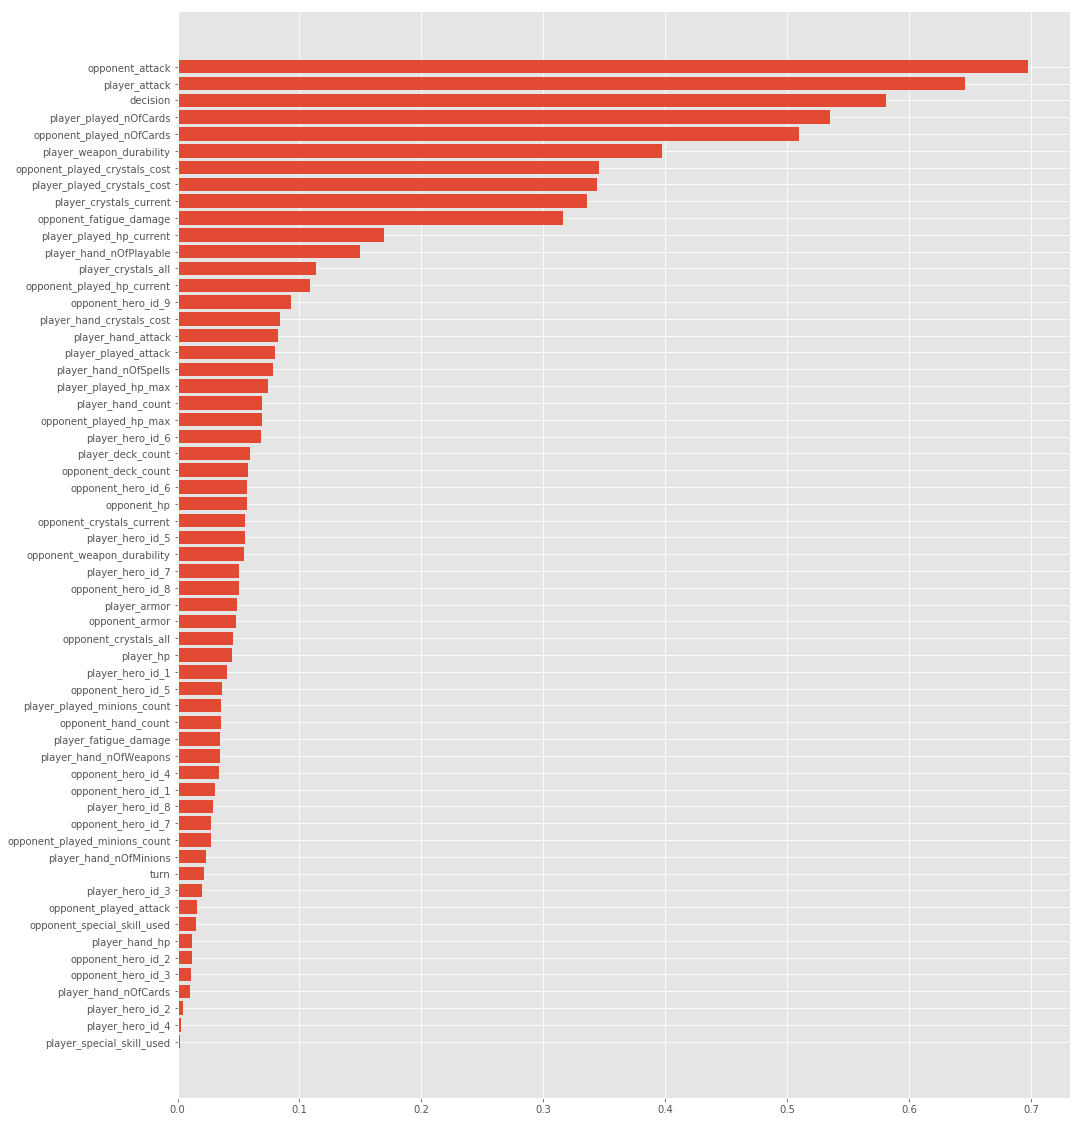

In [19]:
plt.rcParams['figure.figsize'] = (16,20)
plt.barh(xrange(len(indd)), np.abs(lr.coef_[0][indd]))
lab = plt.yticks(xrange(len(indd)), df_data.columns[indd])

## Отбор параметров

In [52]:
selector = RFECV(lr, step=1)

In [53]:
selector.fit(X_train, y_train)

convergence after 18 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.6s finished


convergence after 18 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.0s finished


convergence after 19 epochs took 27 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.6s finished


convergence after 18 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.8s finished


convergence after 17 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.9s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.1s finished


convergence after 18 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.1s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.9s finished


convergence after 18 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.0s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.2s finished


convergence after 17 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.1s finished


convergence after 18 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.0s finished


convergence after 18 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.0s finished


convergence after 17 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.4s finished


convergence after 17 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.2s finished


convergence after 17 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.1s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.8s finished


convergence after 17 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.4s finished


convergence after 17 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.2s finished


convergence after 18 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.0s finished


convergence after 17 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.0s finished


convergence after 17 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.7s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.3s finished


convergence after 18 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.5s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.9s finished


convergence after 18 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.8s finished


convergence after 18 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.3s finished


convergence after 18 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.8s finished


convergence after 18 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.5s finished


convergence after 18 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.1s finished


convergence after 18 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.2s finished


convergence after 18 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.7s finished


convergence after 18 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.3s finished


convergence after 18 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.3s finished


convergence after 18 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.6s finished


convergence after 18 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.2s finished


convergence after 19 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.1s finished


convergence after 19 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.8s finished


convergence after 20 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.5s finished


convergence after 19 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.2s finished


convergence after 19 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.8s finished


convergence after 19 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.6s finished


convergence after 19 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.3s finished


convergence after 19 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.3s finished


convergence after 20 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.9s finished


convergence after 19 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.5s finished


convergence after 20 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.3s finished


convergence after 18 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.9s finished


convergence after 19 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.9s finished


convergence after 19 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.8s finished


convergence after 18 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.1s finished


convergence after 18 epochs took 14 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   14.5s finished


convergence after 18 epochs took 14 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   14.4s finished


convergence after 20 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.0s finished


convergence after 17 epochs took 13 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.5s finished


convergence after 17 epochs took 12 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.1s finished


convergence after 18 epochs took 12 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.9s finished


convergence after 17 epochs took 9 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    8.5s finished


convergence after 18 epochs took 8 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    8.7s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.4s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.1s finished


convergence after 18 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.8s finished


convergence after 19 epochs took 27 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.1s finished


convergence after 20 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.7s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.7s finished


convergence after 18 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.3s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.7s finished


convergence after 18 epochs took 27 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.3s finished


convergence after 17 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.4s finished


convergence after 18 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.5s finished


convergence after 18 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.1s finished


convergence after 20 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.8s finished


convergence after 17 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.9s finished


convergence after 17 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.7s finished


convergence after 19 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.9s finished


convergence after 17 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.2s finished


convergence after 18 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.3s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.2s finished


convergence after 18 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.8s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.9s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.5s finished


convergence after 18 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.6s finished


convergence after 17 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.5s finished


convergence after 19 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.4s finished


convergence after 19 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.9s finished


convergence after 18 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.6s finished


convergence after 17 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.8s finished


convergence after 18 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.7s finished


convergence after 18 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.4s finished


convergence after 17 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.2s finished


convergence after 17 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.0s finished


convergence after 18 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.8s finished


convergence after 18 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.5s finished


convergence after 19 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.1s finished


convergence after 20 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.3s finished


convergence after 20 epochs took 414 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  6.9min finished


convergence after 19 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.9s finished


convergence after 20 epochs took 192 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.2min finished


convergence after 19 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.9s finished


convergence after 20 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.3s finished


convergence after 19 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.6s finished


convergence after 20 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.3s finished


convergence after 22 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.3s finished


convergence after 19 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.8s finished


convergence after 20 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.5s finished


convergence after 20 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.3s finished


convergence after 20 epochs took 17 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.1s finished


convergence after 19 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.0s finished


convergence after 18 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.1s finished


convergence after 19 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.0s finished


convergence after 19 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.3s finished


convergence after 18 epochs took 14 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   14.2s finished


convergence after 19 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.4s finished


convergence after 18 epochs took 14 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.2s finished


convergence after 18 epochs took 12 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.0s finished


convergence after 18 epochs took 12 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.6s finished


convergence after 14 epochs took 7 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.8s finished


convergence after 15 epochs took 7 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.9s finished


convergence after 21 epochs took 33 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   33.6s finished


convergence after 18 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.3s finished


convergence after 17 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.7s finished


convergence after 19 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.1s finished


convergence after 18 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.5s finished


convergence after 19 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.7s finished


convergence after 18 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.5s finished


convergence after 18 epochs took 24 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.2s finished


convergence after 18 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.5s finished


convergence after 18 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.5s finished


convergence after 18 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.3s finished


convergence after 18 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.2s finished


convergence after 18 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.5s finished


convergence after 18 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.8s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.3s finished


convergence after 20 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.5s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.8s finished


convergence after 18 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.5s finished


convergence after 19 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.4s finished


convergence after 19 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.0s finished


convergence after 22 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.3s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.3s finished


convergence after 20 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.8s finished


convergence after 18 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.6s finished


convergence after 20 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.7s finished


convergence after 19 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.4s finished


convergence after 19 epochs took 23 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   23.4s finished


convergence after 20 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   24.3s finished


convergence after 19 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.1s finished


convergence after 19 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.8s finished


convergence after 18 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.8s finished


convergence after 18 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.8s finished


convergence after 20 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.9s finished


convergence after 19 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.0s finished


convergence after 20 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.5s finished


convergence after 19 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.6s finished


convergence after 20 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.7s finished


convergence after 18 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   19.9s finished


convergence after 20 epochs took 20 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.3s finished


convergence after 19 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.2s finished


convergence after 20 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.4s finished


convergence after 20 epochs took 19 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.2s finished


convergence after 22 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.4s finished


convergence after 20 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   20.6s finished


convergence after 19 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   18.5s finished


convergence after 19 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.2s finished


convergence after 19 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   16.3s finished


convergence after 18 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.2s finished


convergence after 18 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.1s finished


convergence after 18 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.0s finished


convergence after 18 epochs took 16 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.7s finished


convergence after 18 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.2s finished


convergence after 19 epochs took 15 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   15.1s finished


convergence after 17 epochs took 13 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.6s finished


convergence after 17 epochs took 12 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.4s finished


convergence after 18 epochs took 12 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.3s finished


convergence after 14 epochs took 10 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    9.3s finished


convergence after 17 epochs took 9 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    8.7s finished


convergence after 13 epochs took 6 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.2s finished


convergence after 17 epochs took 39 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   38.8s finished


convergence after 17 epochs took 38 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   37.9s finished


convergence after 17 epochs took 38 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   38.0s finished


convergence after 18 epochs took 41 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   41.5s finished


convergence after 17 epochs took 36 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   37.0s finished


convergence after 17 epochs took 41 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   41.1s finished


convergence after 17 epochs took 36 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   36.3s finished


convergence after 17 epochs took 37 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   36.8s finished


convergence after 17 epochs took 39 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   38.9s finished


convergence after 17 epochs took 38 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   38.6s finished


convergence after 19 epochs took 42 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   42.1s finished


convergence after 17 epochs took 38 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   37.7s finished


convergence after 17 epochs took 38 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   38.1s finished


convergence after 18 epochs took 38 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   38.3s finished


convergence after 17 epochs took 34 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   34.8s finished


convergence after 18 epochs took 37 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   37.3s finished


convergence after 17 epochs took 36 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   36.0s finished


convergence after 17 epochs took 36 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   35.4s finished


convergence after 18 epochs took 36 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   36.2s finished


convergence after 17 epochs took 34 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   33.3s finished


convergence after 17 epochs took 34 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   33.7s finished


RFECV(cv=None,
   estimator=LogisticRegression(C=0.0334, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=2, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [54]:
selector.ranking_

array([ 1,  8,  3,  1,  1, 15,  2,  1,  1,  1,  1,  1,  7,  1,  1,  1, 20,
        1,  1,  1,  1, 10,  1,  1,  1, 14,  1,  1,  1,  1,  1,  1,  1,  1,
       11,  1,  5, 17,  1,  1,  1,  1, 13,  1, 16, 12,  1,  4,  1,  1,  1,
        1, 18,  9, 19,  1,  1,  1,  6])

In [62]:
selector.n_features_

40

In [57]:
indx = selector.support_

In [84]:
indx

array([ 1,  8,  3,  1,  1, 15,  2,  1,  1,  1,  1,  1,  7,  1,  1,  1, 20,
        1,  1,  1,  1, 10,  1,  1,  1, 14,  1,  1,  1,  1,  1,  1,  1,  1,
       11,  1,  5, 17,  1,  1,  1,  1, 13,  1, 16, 12,  1,  4,  1,  1,  1,
        1, 18,  9, 19,  1,  1,  1,  6])

In [61]:
X_train[:,indx].shape

(2000000, 40)

In [ ]:
lr = LogisticRegression(solver='sag', verbose=2, n_jobs=4)

In [86]:
gs = GridSearchCV(lr, {'C':np.linspace(0.0001, 0.5, 10)}, scoring='roc_auc', verbose=2)

In [87]:
gs.fit(X_train[:, indx], y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.0001 ........................................................
convergence after 13 epochs took 21 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.2s finished


[CV] ......................................... C=0.0001, total=  24.3s
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s


convergence after 14 epochs took 22 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   21.4s finished


[CV] ......................................... C=0.0001, total=  24.9s
[CV] C=0.0001 ........................................................
convergence after 12 epochs took 18 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   17.9s finished


[CV] ......................................... C=0.0001, total=  20.6s
[CV] C=0.0556444444444 ...............................................
convergence after 19 epochs took 32 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   32.3s finished


[CV] ................................ C=0.0556444444444, total=  35.4s
[CV] C=0.0556444444444 ...............................................
convergence after 18 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.1s finished


[CV] ................................ C=0.0556444444444, total=  33.8s
[CV] C=0.0556444444444 ...............................................
convergence after 18 epochs took 32 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   32.4s finished


[CV] ................................ C=0.0556444444444, total=  36.3s
[CV] C=0.111188888889 ................................................
convergence after 18 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.9s finished


[CV] ................................. C=0.111188888889, total=  35.2s
[CV] C=0.111188888889 ................................................
convergence after 17 epochs took 33 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   33.1s finished


[CV] ................................. C=0.111188888889, total=  38.6s
[CV] C=0.111188888889 ................................................
convergence after 17 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.3s finished


[CV] ................................. C=0.111188888889, total=  32.8s
[CV] C=0.166733333333 ................................................
convergence after 18 epochs took 27 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.4s finished


[CV] ................................. C=0.166733333333, total=  30.3s
[CV] C=0.166733333333 ................................................
convergence after 18 epochs took 27 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   27.0s finished


[CV] ................................. C=0.166733333333, total=  29.5s
[CV] C=0.166733333333 ................................................
convergence after 17 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.5s finished


[CV] ................................. C=0.166733333333, total=  33.8s
[CV] C=0.222277777778 ................................................
convergence after 18 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.6s finished


[CV] ................................. C=0.222277777778, total=  33.7s
[CV] C=0.222277777778 ................................................
convergence after 19 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.7s finished


[CV] ................................. C=0.222277777778, total=  32.7s
[CV] C=0.222277777778 ................................................
convergence after 17 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.6s finished


[CV] ................................. C=0.222277777778, total=  31.4s
[CV] C=0.277822222222 ................................................
convergence after 17 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.0s finished


[CV] ................................. C=0.277822222222, total=  29.0s
[CV] C=0.277822222222 ................................................
convergence after 17 epochs took 35 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   35.1s finished


[CV] ................................. C=0.277822222222, total=  38.0s
[CV] C=0.277822222222 ................................................
convergence after 16 epochs took 25 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   25.0s finished


[CV] ................................. C=0.277822222222, total=  30.3s
[CV] C=0.333366666667 ................................................
convergence after 17 epochs took 26 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.5s finished


[CV] ................................. C=0.333366666667, total=  29.3s
[CV] C=0.333366666667 ................................................
convergence after 18 epochs took 32 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.5s finished


[CV] ................................. C=0.333366666667, total=  34.0s
[CV] C=0.333366666667 ................................................
convergence after 18 epochs took 36 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   36.4s finished


[CV] ................................. C=0.333366666667, total=  40.2s
[CV] C=0.388911111111 ................................................
convergence after 17 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.8s finished


[CV] ................................. C=0.388911111111, total=  32.5s
[CV] C=0.388911111111 ................................................
convergence after 18 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.3s finished


[CV] ................................. C=0.388911111111, total=  34.6s
[CV] C=0.388911111111 ................................................
convergence after 17 epochs took 29 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.6s finished


[CV] ................................. C=0.388911111111, total=  33.9s
[CV] C=0.444455555556 ................................................
convergence after 18 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.7s finished


[CV] ................................. C=0.444455555556, total=  35.0s
[CV] C=0.444455555556 ................................................
convergence after 18 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.2s finished


[CV] ................................. C=0.444455555556, total=  32.6s
[CV] C=0.444455555556 ................................................
convergence after 18 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   30.5s finished


[CV] ................................. C=0.444455555556, total=  33.6s
[CV] C=0.5 ...........................................................
convergence after 19 epochs took 31 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.5s finished


[CV] ............................................ C=0.5, total=  35.6s
[CV] C=0.5 ...........................................................
convergence after 18 epochs took 30 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   29.4s finished


[CV] ............................................ C=0.5, total=  33.7s
[CV] C=0.5 ...........................................................
convergence after 17 epochs took 28 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   28.3s finished


[CV] ............................................ C=0.5, total=  32.0s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.7min finished


convergence after 17 epochs took 42 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   42.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   5.56444e-02,   1.11189e-01,   1.66733e-01,
         2.22278e-01,   2.77822e-01,   3.33367e-01,   3.88911e-01,
         4.44456e-01,   5.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=2)

In [88]:
gs.best_score_

0.7300394526420606

Итоговое качество только упало, так что этот вариант отпадает. 

## Добавление всех тестовых данных

In [42]:
df_list = []
for chunk in range(5,8):
    filepath = './deprecated_testData_tabular/testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))

df_val = pd.concat(df_list)
del df_list

In [43]:
df_val.decision = pd.read_csv('./deprecated_testLabels.txt', sep='\n', header=None)

In [44]:
df_val.shape

(1250000, 45)

In [45]:
df_val.columns = df_val.columns.str.replace('.', '_')
df_val = df_val.set_index('gamestate_id')
new_feat = ohe.fit_transform(df_val.opponent_hero_card_id.values.reshape(-1,1))
df1 = pd.DataFrame(new_feat, columns=["opponent_hero_id_"+str(i+1) for i in xrange(new_feat.shape[1])], index=df_val.index)
new_feat1 = ohe.fit_transform(df_val.player_hero_card_id.values.reshape(-1,1))
df2 = pd.DataFrame(new_feat1, columns=["player_hero_id_"+str(i+1) for i in xrange(new_feat1.shape[1])], index=df_val.index)
df_val = pd.concat([df_val, df1, df2], axis=1)
del_cols = ["opponent_hero_card_id", "player_hero_card_id"]
cols = [x for x in df_val.columns if x not in del_cols]
df_val = df_val[cols]

In [46]:
X_val = df_val.drop('decision', axis=1)
X_val = dataScaler.transform(X_val)

In [47]:
y_val = df_val.decision.values

In [56]:
lr = LogisticRegression(solver='sag', verbose=2, n_jobs=4, C=0.0334)

In [57]:
lr.fit(np.r_[X_train, X_val], np.r_[y_train, y_val])

convergence after 17 epochs took 61 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.0min finished


LogisticRegression(C=0.0334, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
          solver='sag', tol=0.0001, verbose=2, warm_start=False)

## XGBoost

In [41]:
xgb = XGBClassifier(silent=False, max_depth=4, n_estimators=2000)

In [42]:
%%time
xgb.fit(np.r_[X_train, X_val], np.r_[y_train, y_val])

CPU times: user 6h 25min 29s, sys: 4min 26s, total: 6h 29min 56s
Wall time: 6h 38min 4s


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

## К ближайших соседей

In [ ]:
X = np.r_[X_train, X_val]

In [ ]:
y = np.r_[y_train, y_val]

In [ ]:
knc = KNeighborsClassifier(n_jobs=4,n_neighbors=20)

In [ ]:
best = 0
for i in xrange(20):
    x1, x2, y1, y2 = train_test_split(X, y,test_size=0.5)
    ind1 = np.random.randint(0, len(x1), size=100000)
    ind2 = np.random.randint(0, len(x2), size=100000)
    knc.fit(x1[ind1], y1[ind1])
    pred = roc_auc_score(y2[ind2], knc.predict_proba(x2[ind2])[:,1])
    if pred > best:
        best = pred
        best_ind = ind1.copy()

In [50]:
knc.fit(X_train[best_ind], y_train[best_ind])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=20, p=2,
           weights='uniform')

Метод хорош, но ооооочень долгий, поэтому не в этот раз

## Загрузка тест сета

In [66]:
df_test = pd.read_csv('./testData_tabular.csv')
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')
new_feat = ohe.fit_transform(df_test.opponent_hero_card_id.values.reshape(-1,1))
df1 = pd.DataFrame(new_feat, columns=["opponent_hero_id_"+str(i+1) for i in xrange(new_feat.shape[1])], index=df_test.index)
new_feat1 = ohe.fit_transform(df_test.player_hero_card_id.values.reshape(-1,1))
df2 = pd.DataFrame(new_feat1, columns=["player_hero_id_"+str(i+1) for i in xrange(new_feat1.shape[1])], index=df_test.index)
df_test = pd.concat([df_test, df1, df2], axis=1)
del_cols = ["opponent_hero_card_id", "player_hero_card_id"]
cols = [x for x in df_test.columns if x not in del_cols]
df_test = df_test[cols]

In [76]:
X_test = df_test.drop('decision', axis=1)

In [77]:
X_test = dataScaler.transform(X_test)

In [60]:
y_test = df_test.decision

In [78]:
y2 = xgb.predict_proba(X_test)

## Выделение данных из JSON

В  JSON данных, помимо нам уже известных есть более детальные данные. А именно, например, конкретные карты на руках игрока, а также уже отыгранные карты и с той, и с другой стороны. Выделим карты на руках:

In [2]:
import json

In [29]:
text_data = []
for chunk in range(1,5):
    with open('./trainingData_JSON_chunk%d.json' % chunk) as f:
        text_data.extend(f.readlines())

In [30]:
len(text_data)

2000000

In [31]:
ids = []

In [32]:
for i, item  in enumerate(text_data):
    if i % 100000 == 0:
        print i
    game = json.loads(item)
    for card in game['player']['hand']:
        ids.append(card['name'])
    for card in game['player']['played_cards']:
        ids.append(card['name'])
    for card in game['opponent']['played_cards']:
        ids.append(card['name'])

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000


In [33]:
text_data = []
for chunk in range(5,8):
    with open('./dtestData_JSON_chunk%d.json' % chunk) as f:
        text_data.extend(f.readlines())

In [34]:
for i, item  in enumerate(text_data):
    if i % 100000 == 0:
        print i
    game = json.loads(item)
    for card in game['player']['hand']:
        ids.append(card['name'])
    for card in game['player']['played_cards']:
        ids.append(card['name'])
    for card in game['opponent']['played_cards']:
        ids.append(card['name'])

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [35]:
text_data = []
for chunk in range(8,11):
    with open('testData_JSON/testData_JSON_chunk%d.json' % chunk) as f:
        text_data.extend(f.readlines())

In [36]:
for i, item  in enumerate(text_data):
    if i % 100000 == 0:
        print i
    game = json.loads(item)
    for card in game['player']['hand']:
        ids.append(card['name'])
    for card in game['player']['played_cards']:
        ids.append(card['name'])
    for card in game['opponent']['played_cards']:
        ids.append(card['name'])

0
100000
200000
300000
400000
500000
600000
700000


In [157]:
for i, game in enumerate(json_data):
    if i % 100000 == 0:
        print i
    
    for card in game['player']['hand']:
        ids.append(card['id'])
    for card in game['player']['played_cards']:
        ids.append(card['id'])
    for card in game['opponent']['played_cards']:
        ids.append(card['id'])


0
100000
200000
300000
400000


In [ ]:
del text_data

In [37]:
len(ids)

33248641

In [38]:
id_set = set(ids)

In [39]:
len(id_set)

118

In [40]:
id_set

{u'Acidic Swamp Ooze',
 u'Ancestral Healing',
 u'Animal Companion',
 u'Arcane Explosion',
 u'Arcane Intellect',
 u'Arcane Missiles',
 u'Arcane Shot',
 u'Arcanite Reaper',
 u'Archmage',
 u"Assassin's Blade",
 u'Assassinate',
 u'Backstab',
 u'Blessing of Kings',
 u'Bloodfen Raptor',
 u'Bloodlust',
 u'Boar',
 u'Booty Bay Bodyguard',
 u'Boulderfist Ogre',
 u'Chillwind Yeti',
 u'Claw',
 u'Cleave',
 u'Consecration',
 u'Core Hound',
 u'Darkscale Healer',
 u'Deadly Poison',
 u'Dire Wolf Alpha',
 u'Divine Spirit',
 u'Dragonling Mechanic',
 u'Dread Infernal',
 u'Elven Archer',
 u'Excess Mana',
 u'Execute',
 u'Fan of Knives',
 u'Fen Creeper',
 u'Fiery War Axe',
 u'Fire Elemental',
 u'Fireball',
 u'Flamestrike',
 u'Flametongue Totem',
 u'Frog',
 u'Frost Nova',
 u'Frostbolt',
 u'Frostwolf Grunt',
 u'Frostwolf Warlord',
 u'Gnomish Inventor',
 u'Goldshire Footman',
 u'Guardian of Kings',
 u'Gurubashi Berserker',
 u'Hammer of Wrath',
 u'Healing Totem',
 u'Hellfire',
 u'Hex',
 u'Holy Nova',
 u'Holy Smi

In [42]:
count = Counter(ids)

#### Частота использования игроками отдельных карт

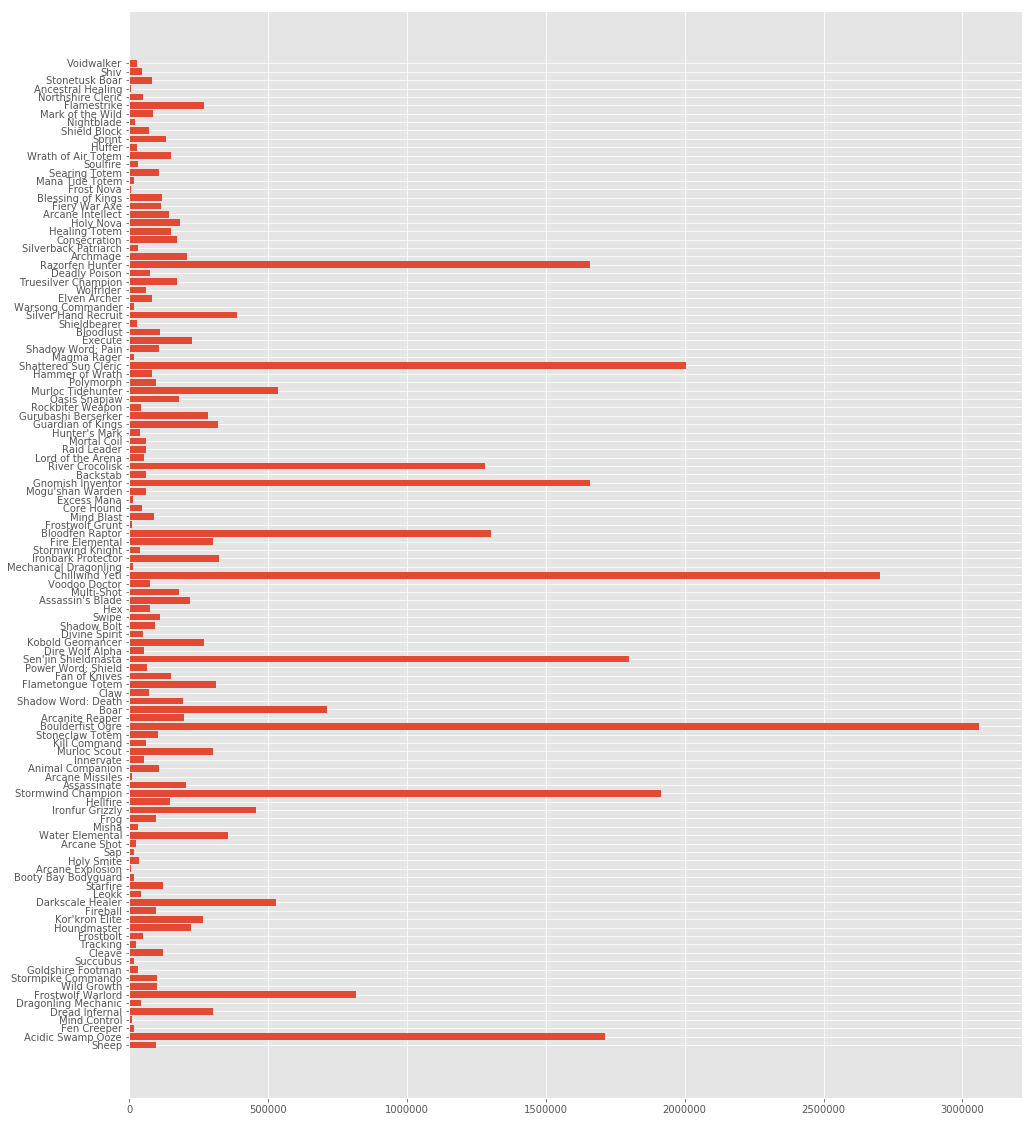

In [70]:
plt.rcParams['figure.figsize'] = (16,20)
plt.barh(xrange(len(count)), count.values())
lab = plt.yticks(xrange(len(count)), count.keys())

In [112]:
new_ind = np.argsort(np.abs(lr.coef_))[::-1][0]

In [65]:
new_ind = new_ind[new_ind > 58]

In [86]:
new_ind

array([176, 122,  62, 154,  64, 152, 146,  74,  75, 145,  81,  84, 141,
        86, 175,  92, 137, 136, 123, 114, 124, 125, 127, 129, 156, 108,
       131, 104, 101,  99,  98, 134, 130, 157,  60, 172, 161, 166, 165,
       170, 155,   6,  77,  82,  11,  23, 142,   5,  16,  41,  54,  37,
        43,  44,  53, 159,  72, 140,  39,  48,   1,  59, 105,  52,  45,
        42,  12,  21,  36,  28,  22,  51,  34,  46,  89,  25,   2, 147,
        15, 143, 103, 171,  13, 132,  57,  56,   7,  49, 151,  47,  76,
       148,   4,  27,  65,  20,  94,   9, 174, 117,  35, 138,  58,  55,
        83, 121, 162,  66,  33, 112,   8,  50, 173,  93,  32, 118, 115,
       100,  73, 168,  91,  88,  38,  87, 150,  18,  63, 169,  67, 149,
       106, 135,  30,  70,  40,  68, 120, 164, 144, 133, 107, 102, 116,
       113, 167,  69, 109, 139,  78,  10,  31,  61,  80,  79,  26,  97,
        96, 153, 128, 110, 163,  19, 160, 158, 126,  95,  17, 119,  85,
        24,  29,  90,  71, 111,   0,  14,   3])

In [89]:
names = np.array(df_data.columns.tolist()+cards)
names

array([u'decision', u'turn', u'opponent_armor', u'opponent_attack',
       u'opponent_hp', u'opponent_special_skill_used',
       u'opponent_weapon_durability', u'opponent_crystals_all',
       u'opponent_crystals_current', u'opponent_deck_count',
       u'opponent_fatigue_damage', u'opponent_hand_count',
       u'opponent_played_minions_count', u'player_armor', u'player_attack',
       u'player_hp', u'player_special_skill_used',
       u'player_weapon_durability', u'player_crystals_all',
       u'player_crystals_current', u'player_deck_count',
       u'player_fatigue_damage', u'player_hand_count',
       u'player_played_minions_count', u'opponent_played_nOfCards',
       u'opponent_played_attack', u'opponent_played_crystals_cost',
       u'opponent_played_hp_current', u'opponent_played_hp_max',
       u'player_played_nOfCards', u'player_played_attack',
       u'player_played_crystals_cost', u'player_played_hp_current',
       u'player_played_hp_max', u'player_hand_nOfMinions',
       

#### Важность признаков вместе с картами

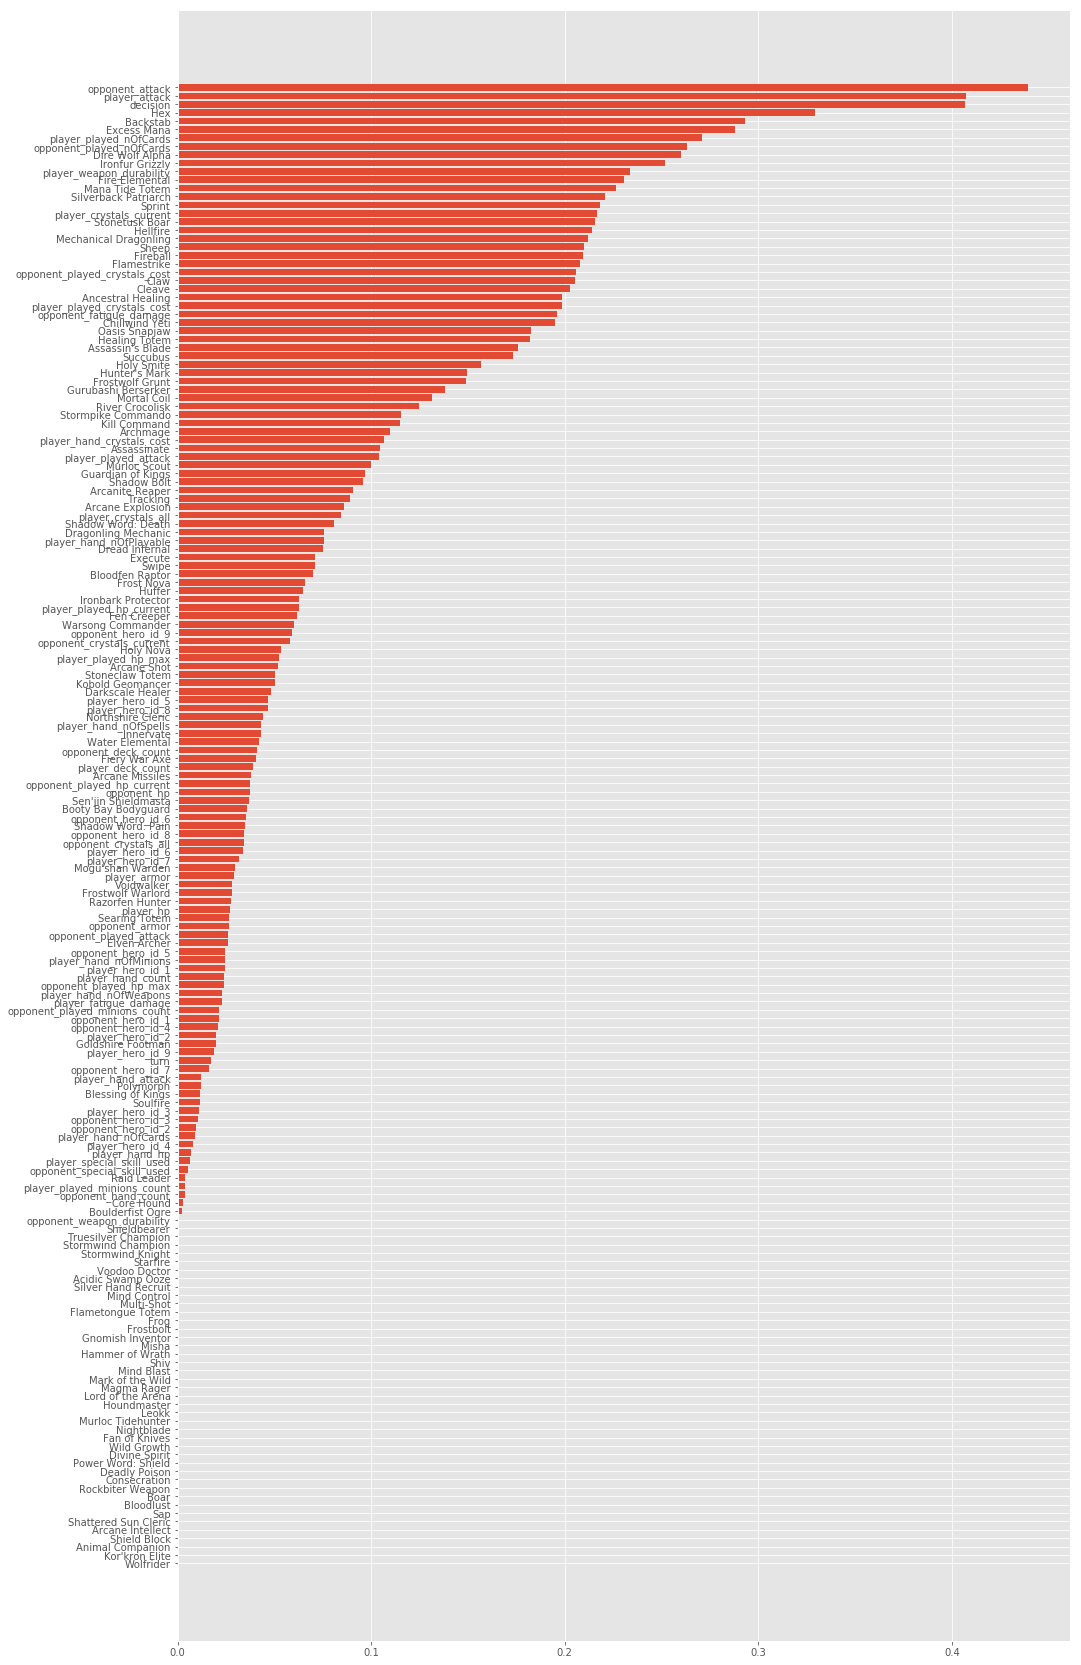

In [117]:
plt.rcParams['figure.figsize'] = (16,30)
plt.barh(xrange(X_train.shape[1]), np.abs(lr.coef_[0][new_ind]))
lab = plt.yticks(xrange(X_train.shape[1]), names[new_ind])

In [113]:
new_ind1 = new_ind[new_ind > 58] - 59

In [114]:
new_ind2 = new_ind[new_ind > 58]

In [115]:
len(new_ind1)

118

#### Важность карт

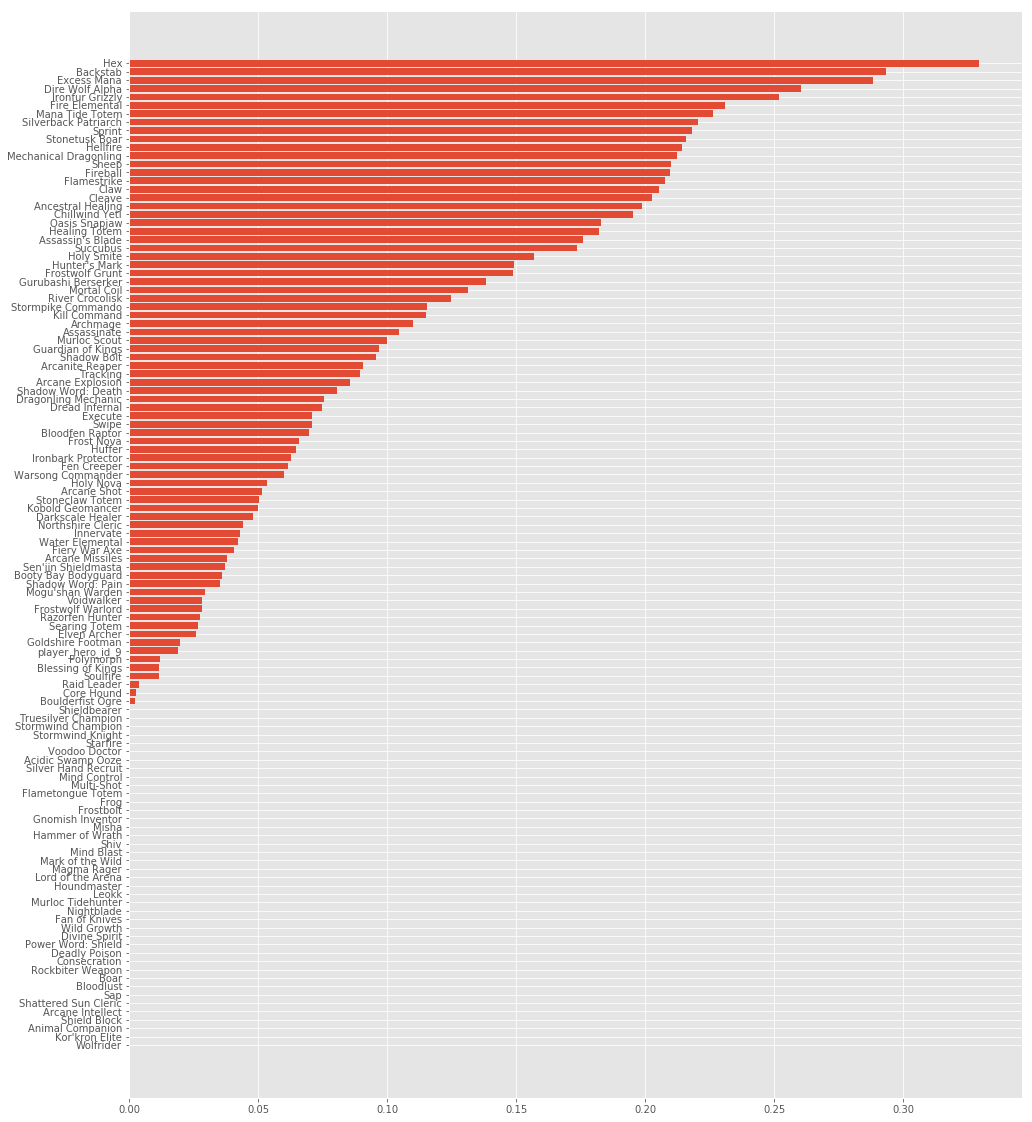

In [118]:
plt.rcParams['figure.figsize'] = (16,20)
plt.barh(xrange(len(cards)), np.abs(lr.coef_[0][new_ind2]))
lab = plt.yticks(xrange(len(cards)), names[new_ind2])

In [71]:
cards = list(id_set)

In [4]:
cols = ['gamestate_id']

In [11]:
cols = ['hand_card_'+x for x in cards]

In [35]:
data = np.zeros((3250000, len(cards)+1))

In [36]:
cards_dict = {x: i+1 for i, x in enumerate(cards)}

In [8]:
cards_dict

{u'Acidic Swamp Ooze': 1,
 u'Ancestral Healing': 2,
 u'Animal Companion': 3,
 u'Arcane Explosion': 4,
 u'Arcane Intellect': 5,
 u'Arcane Missiles': 6,
 u'Arcane Shot': 7,
 u'Arcanite Reaper': 8,
 u'Archmage': 9,
 u"Assassin's Blade": 10,
 u'Assassinate': 11,
 u'Backstab': 12,
 u'Blessing of Kings': 13,
 u'Bloodfen Raptor': 14,
 u'Bloodlust': 15,
 u'Boar': 16,
 u'Booty Bay Bodyguard': 17,
 u'Boulderfist Ogre': 18,
 u'Chillwind Yeti': 19,
 u'Claw': 20,
 u'Cleave': 21,
 u'Consecration': 22,
 u'Core Hound': 23,
 u'Darkscale Healer': 24,
 u'Deadly Poison': 25,
 u'Dire Wolf Alpha': 26,
 u'Divine Spirit': 27,
 u'Dragonling Mechanic': 28,
 u'Dread Infernal': 29,
 u'Elven Archer': 30,
 u'Excess Mana': 31,
 u'Execute': 32,
 u'Fan of Knives': 33,
 u'Fen Creeper': 34,
 u'Fiery War Axe': 35,
 u'Fire Elemental': 36,
 u'Fireball': 37,
 u'Flamestrike': 38,
 u'Flametongue Totem': 39,
 u'Frog': 40,
 u'Frost Nova': 41,
 u'Frostbolt': 42,
 u'Frostwolf Grunt': 43,
 u'Frostwolf Warlord': 44,
 u'Gnomish Inve

In [37]:
text_data = []
for chunk in range(1,5):
    with open('./trainingData_JSON_chunk%d.json' % chunk) as f:
        text_data.extend(f.readlines())
        
for chunk in range(5,8):
    with open('./dtestData_JSON_chunk%d.json' % chunk) as f:
        text_data.extend(f.readlines())

print 'reading complete'

for i, item  in enumerate(text_data):
    if i % 100000 == 0:
        print i
    game = json.loads(item)
    data[i, 0] = game['gamestate_id']
    for card in game['player']['hand']:
        data[i, cards_dict[card['name']]] += 1

reading complete
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000


In [38]:
del text_data

In [26]:
data[:,1:].max()

2.0

In [23]:
data_test[:,1:].max()

2.0

In [39]:
data[:,1:] /= 2.

In [14]:
text_data = []
for chunk in range(8,11):
    with open('testData_JSON/testData_JSON_chunk%d.json' % chunk) as f:
        text_data.extend(f.readlines())

print 'reading complete'

data_test = np.zeros((len(text_data), len(cards)+1))

for i, item  in enumerate(text_data):
    if i % 100000 == 0:
        print i
    game = json.loads(item)
    data_test[i, 0] = game['gamestate_id']
    for card in game['player']['hand']:
        data_test[i, cards_dict[card['name']]] += 1

reading complete
0
100000
200000
300000
400000
500000
600000
700000


In [30]:
data_test[:,1:] /= 2.

## Stacking и получение итогового результата

В качестве результата возьмем среднее между результатами xgboost и logregression

In [51]:
X_train = np.c_[X_train, data[:,1:]]

In [56]:
y_train = np.r_[y_train, y_val]

In [52]:
X_train.shape

(3250000, 177)

In [53]:
lr = LogisticRegression(solver='sag', verbose=2, n_jobs=4)

In [60]:
gs = GridSearchCV(lr, {'C':np.linspace(0.0001, 0.4, 10)}, scoring='roc_auc', verbose=2)

In [61]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.0001 ........................................................
convergence after 15 epochs took 70 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV] ......................................... C=0.0001, total= 1.6min
[CV] C=0.0001 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


convergence after 15 epochs took 75 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV] ......................................... C=0.0001, total= 1.7min
[CV] C=0.0001 ........................................................
convergence after 14 epochs took 69 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV] ......................................... C=0.0001, total= 1.6min
[CV] C=0.0445333333333 ...............................................
convergence after 35 epochs took 157 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.6min finished


[CV] ................................ C=0.0445333333333, total= 3.1min
[CV] C=0.0445333333333 ...............................................
convergence after 34 epochs took 160 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.7min finished


[CV] ................................ C=0.0445333333333, total= 3.1min
[CV] C=0.0445333333333 ...............................................
convergence after 36 epochs took 168 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV] ................................ C=0.0445333333333, total= 3.3min
[CV] C=0.0889666666667 ...............................................
convergence after 36 epochs took 167 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV] ................................ C=0.0889666666667, total= 3.3min
[CV] C=0.0889666666667 ...............................................
convergence after 35 epochs took 169 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV] ................................ C=0.0889666666667, total= 3.3min
[CV] C=0.0889666666667 ...............................................
convergence after 36 epochs took 167 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV] ................................ C=0.0889666666667, total= 3.3min
[CV] C=0.1334 ........................................................
convergence after 34 epochs took 168 seconds


KeyboardInterrupt: 

In [54]:
lr = LogisticRegression(solver='sag', verbose=2, n_jobs=4, C=0.13)

In [64]:
cs = cross_val_score(lr, X_train, y_train, scoring='roc_auc', verbose=2)

[CV]  ................................................................
convergence after 36 epochs took 172 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.9min finished


[CV] ................................................. , total= 3.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


convergence after 36 epochs took 169 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV] ................................................. , total= 3.3min
[CV]  ................................................................
convergence after 37 epochs took 170 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV] ................................................. , total= 3.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.0min finished


In [65]:
print cs

[ 0.78589702  0.79424439  0.5874458 ]


In [57]:
lr.fit(X_train, y_train)

convergence after 23 epochs took 152 seconds


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.5min finished


LogisticRegression(C=0.13, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False)

In [ ]:
X_test = np.c_[X_test, data_test[:,1:]]

In [ ]:
y4 = lr.predict_proba(X_test)

In [ ]:
y_proba = (y4 + y2) / 2.

In [ ]:
with open('out15.dat', 'w') as f:
    f.write('\n'.join(str(x) for x in y_proba[:,1]))

sir_krabye -- 0.7945